In [41]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import tuplelist
import itertools  
import pandas as pd
import os
import math
import matplotlib.pyplot as plt

In [116]:

#Fair ILP


object = pd.read_pickle(r"data/top25_dfs.pickle")
data = object[1]
num_of_player = 35
data = data[0:num_of_player]
data = data.transpose()
players = data.keys()
nrow = len(data)
ncol = int(data.size/len(data))
l = ncol
rankDic = {}
rankList = []
for i in range(0,25):
    row = data.iloc[i, :]
    rank = {}
    for j in range(0,l):
        rankDic[(i,players[j])] = row[j]
        rank[players[j]] = row[j]
    rankList.append(rank)

itemList = data.keys()
itemList = itemList[0:l]
itemList

G1 = []
G2 = []
row = data.iloc[25, :]
group = row
for i in range(0,l):
    if(row[i] == 0):
        G1.append(players[i])
    else:
        G2.append(players[i])
        

p1 = len(G1)/len(itemList)
p2 = len(G2)/len(itemList)

d = 0.9999



G = []
G.append(G1)
G.append(G2)



p = []
p.append(p1)
p.append(p2)



combinations = [p for p in itertools.product(itemList, repeat=2)]
len(combinations)



scores = []
for tup in combinations:
    x,y = tup
    v = 0
    for i in range(0,25):
        if rankDic[(i,x)] < rankDic[(i,y)]:
            v = v +  1
    scores.append(v)




res = dict(zip(combinations, scores)) 

combinations, scores = gp.multidict(res)


# Declare and initialize model
m = gp.Model('RAP')

# Create decision variables for the RAP model
x = m.addVars(combinations,vtype=GRB.BINARY,name='x')


# Create  constraints
con = m.addConstrs((x[i,i] == 0  for i in itemList ), name='c0')


# Create  constraints
con = m.addConstrs((x[i,j] + x[j,i]  == 1   for j in itemList for i in itemList if i != j), name='c1')


# Create  constraints
con = m.addConstrs((x[i,j] + x[j,k] + x[k,i]  >= 1 for j in itemList for i in itemList for k in itemList if (i!= j and j!= k and k != i)), name='c2')
#con = m.addConstrs( (gp.quicksum(p[u]*x[i, j] for j in itemList) - gp.quicksum(x[i, k] for k in G[u]) <= d  for i in itemList  for u in  range(0,len(G)) ) ,name='cfair2')



# Objective: maximize total matching score of all assignments
m.setObjective(x.prod(scores), GRB.MINIMIZE)


# Save model for inspection
m.write('RAP.lp')


# Run optimization engine
m.optimize()


row = data.iloc[25, :]
len(m.getVars())


# Display optimal values of decision variables
i = 0
s = 0
scoredict = {}
for v in m.getVars():
   
    i = i + 1
    s = s + v.x
    #print(v.varName, v.x)
    if i % len(itemList) == 0:
        #print(i / len(itemList))
        g = 'g1'
        if (row[int(i / len(itemList)) - 1] == 1):
            g = 'g2'
        scoredict[itemList[int(i / len(itemList)) - 1]] = (s,g)
        s = 0 

#Display optimal total matching score
print('Total matching score: ', m.objVal)



RoutFairIlp = []

for w in sorted(scoredict, key=scoredict.get, reverse=False):
    print(w, scoredict[w])
    RoutFairIlp.append(w)
    

resRank = {}
for p in scoredict.keys():
    resRank[p] = scoredict[p][0]

print("output rank is = ",resRank)

def KendallTau(P,Q):
    combinations = [p for p in itertools.product(players[0:l], repeat=2)]
    distance = 0
    for tup in combinations:
        if P[tup[0]] < P[tup[1]] and  Q[tup[1]] < Q[tup[0]]:
            distance = distance + 1
    return distance




sumKTau = 0 
for i in range(0,len(rankList)):
    rankQ = rankList[i]
    ktau = KendallTau(resRank,rankQ)
    #print(ktau)
    sumKTau = sumKTau + ktau
avgKTau = sumKTau/len(rankList)
print(avgKTau)



Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 40495 rows, 1225 columns and 120225 nonzeros
Model fingerprint: 0xb18ed3e3
Variable types: 0 continuous, 1225 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 6339.0000000
Presolve removed 27405 rows and 630 columns
Presolve time: 0.11s
Presolved: 13090 rows, 595 columns, 39270 nonzeros
Variable types: 0 continuous, 595 integer (595 binary)
Found heuristic solution: objective 3759.0000000

Root relaxation: objective 6.170000e+02, 0 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     617.0000000 

In [117]:
def GrBinaryIPF(rank,group):
    Rho0 = []
    Rho1 = []
    for i in rank:
        if group[i] == 1:
            Rho0.append(i)
        else:
            Rho1.append(i)

    j = 1
    rankDic = {}
    for itm in rank:
        rankDic[itm] = j
        j = j + 1

    urgent = []
    Rout = []
    P1count = 0
    P0count = 0

    Fp0 = len(Rho0)/len(rank)
    Fp1 = len(Rho1)/len(rank)

    i = 1
    while len(Rho0) != 0 or len(Rho1) != 0:
        #print(Rout)
        if P1count >= len(Rho1):
            Rout.extend(Rho0[P0count:len(Rho0)])
            return Rout
        if P1count >= len(Rho0):
            Rout.extend(Rho1[P1count:len(Rho1)])
            return Rout

        if len(urgent) == 0:
            if rankDic[Rho1[P1count]] < rankDic[Rho0[P0count]]:
                Rout.append(Rho1[P1count])
                P1count = P1count + 1
            else:
                Rout.append(Rho0[P0count])
                P0count = P0count + 1
        else:
            if urgent[0] == 'P1':
                Rout.append(Rho1[P1count])
                P1count = P1count + 1
            else:
                Rout.append(Rho0[P0count])
                P0count = P0count + 1
            urgent = []
        # update urgent
        if Fp1 * (i + 1) - P1count >= 1:
            urgent.append('P1')

        if Fp0 * (i + 1) - P0count >= 1:
            urgent.append('P0')
        i = i + 1
        #print(i)
    return  Rout



In [118]:
def kendallTau(A, B):
    pairs = itertools.combinations(A, 2)

    
    distance = 0

    for x, y in pairs:
        #print(x,y)
        a = A[x] - A[y]
        b = B[x] - B[y]

        # if discordant (different signs)
        if (a * b < 0):
            distance += 1

    return distance

In [119]:
RoutRapf = []
for i in  range(20):
    rank = rankList[i]
    fairRanks = []
    minDistance = 100000000
    RoutBinary = GrBinaryIPF(rank,group)

    Pin = rank
    Qin = RoutBinary

    Q = {}
    for r in range(0,len(Rout)):
        Q[Rout[r]] =  r
   
    P = {}
    for i in rank:
        P[i] = Pin[i]
    distance = kendallTau(P, Q)
    if distance < minDistance:
        minDistance = distance
        RoutRapf = Rout
            

In [121]:

sumFail = 0
count = {0:0,1:0}
positionPlot = [5,10,15,20,25,30]
x_GrB = []
y = []
A = [0,1]
P=[p1,p2]
for i in range(0,35):
    itemId = RoutFairIlp[i]
    itemGrp = group[itemId]
    
    count[itemGrp] = count[itemGrp] + 1
    
    print("count = ",count)
    violates = 0
    n = i + 1
    for j in A:
        bot = math.floor(n*P[j])
        top = math.ceil(n*P[j])
        print(j,bot,top)
        if (count[j] > top ) or count[j] < bot:
            violates = violates + 1
    print(n,violates)
    
    
    x_GrB.append((n-sumFail)/n*100)
    if i in positionPlot:
        y.append((n-sumFail)/n*100)
    sumFail =sumFail +  violates
    print('pfairness satisfied by FairILP = ',n,(n-sumFail)/n*100)

count =  {0: 0, 1: 1}
0 0 1
1 0 1
1 0
pfairness satisfied by FairILP =  1 100.0
count =  {0: 0, 1: 2}
0 0 1
1 1 2
2 0
pfairness satisfied by FairILP =  2 100.0
count =  {0: 1, 1: 2}
0 1 2
1 1 2
3 0
pfairness satisfied by FairILP =  3 100.0
count =  {0: 1, 1: 3}
0 1 2
1 2 3
4 0
pfairness satisfied by FairILP =  4 100.0
count =  {0: 1, 1: 4}
0 2 3
1 2 3
5 2
pfairness satisfied by FairILP =  5 60.0
count =  {0: 2, 1: 4}
0 2 3
1 3 4
6 0
pfairness satisfied by FairILP =  6 66.66666666666666
count =  {0: 3, 1: 4}
0 3 4
1 3 4
7 0
pfairness satisfied by FairILP =  7 71.42857142857143
count =  {0: 3, 1: 5}
0 3 4
1 4 5
8 0
pfairness satisfied by FairILP =  8 75.0
count =  {0: 3, 1: 6}
0 4 5
1 4 5
9 2
pfairness satisfied by FairILP =  9 55.55555555555556
count =  {0: 4, 1: 6}
0 4 5
1 5 6
10 0
pfairness satisfied by FairILP =  10 60.0
count =  {0: 5, 1: 6}
0 5 6
1 5 6
11 0
pfairness satisfied by FairILP =  11 63.63636363636363
count =  {0: 5, 1: 7}
0 5 6
1 6 7
12 0
pfairness satisfied by FairILP =

In [122]:
y

[66.66666666666666,
 63.63636363636363,
 75.0,
 71.42857142857143,
 61.53846153846154,
 61.29032258064516]

In [123]:
sumFail = 0
count = {0:0,1:0}
positionPlot = [5,10,15,20,25,30]
x_GrB = []
x = []
A = [0,1]
P=[p1,p2]
for i in range(0,35):
    itemId = RoutRapf[i]
    itemGrp = group[itemId]
    
    count[itemGrp] = count[itemGrp] + 1
    
    print("count = ",count)
    violates = 0
    n = i + 1
    for j in A:
        bot = math.floor(n*P[j])
        top = math.ceil(n*P[j])
        print(j,bot,top)
        if (count[j] > top ) or count[j] < bot:
            violates = violates + 1
    print(n,violates)
    
    
    x_GrB.append((n-sumFail)/n*100)
    if i in positionPlot:
        x.append((n-sumFail)/n*100)
    sumFail =sumFail +  violates
    print('pfairness satisfied by FairILP = ',n,(n-sumFail)/n*100)

count =  {0: 0, 1: 1}
0 0 1
1 0 1
1 0
pfairness satisfied by FairILP =  1 100.0
count =  {0: 0, 1: 2}
0 0 1
1 1 2
2 0
pfairness satisfied by FairILP =  2 100.0
count =  {0: 1, 1: 2}
0 1 2
1 1 2
3 0
pfairness satisfied by FairILP =  3 100.0
count =  {0: 2, 1: 2}
0 1 2
1 2 3
4 0
pfairness satisfied by FairILP =  4 100.0
count =  {0: 3, 1: 2}
0 2 3
1 2 3
5 0
pfairness satisfied by FairILP =  5 100.0
count =  {0: 3, 1: 3}
0 2 3
1 3 4
6 0
pfairness satisfied by FairILP =  6 100.0
count =  {0: 4, 1: 3}
0 3 4
1 3 4
7 0
pfairness satisfied by FairILP =  7 100.0
count =  {0: 4, 1: 4}
0 3 4
1 4 5
8 0
pfairness satisfied by FairILP =  8 100.0
count =  {0: 5, 1: 4}
0 4 5
1 4 5
9 0
pfairness satisfied by FairILP =  9 100.0
count =  {0: 5, 1: 5}
0 4 5
1 5 6
10 0
pfairness satisfied by FairILP =  10 100.0
count =  {0: 6, 1: 5}
0 5 6
1 5 6
11 0
pfairness satisfied by FairILP =  11 100.0
count =  {0: 6, 1: 6}
0 5 6
1 6 7
12 0
pfairness satisfied by FairILP =  12 100.0
count =  {0: 6, 1: 7}
0 5 6
1 7 8


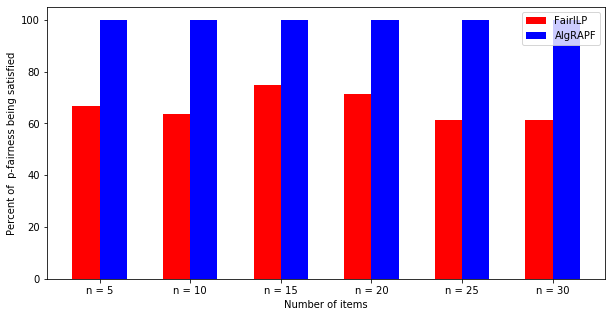

In [125]:
import numpy as np
# Numbers of pairs of bars you want
N = 6

# Data on X-axis
position = [0,1,2,3,4,5]
# Specify the values of blue bars (height)
blue_bar = []
orange_bar = []
for i in position:
    blue_bar.append(y[i]) 
    orange_bar.append(x[i]) 

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, blue_bar , width, label='FairILP',color = 'red')
plt.bar(ind + width, orange_bar, width, label='AlgRAPF',color = 'blue')

plt.xlabel('Number of items')
plt.ylabel('Percent of  p-fairness being satisfied')

plt.xticks(ind + width / 2, ('n = 5','n = 10','n = 15','n = 20','n = 25','n = 30' ))
plt.legend(loc='best')
plt.show()